A basic example of XGboost classification using the titanic dataset.

Note: XGBoost can't handle categorical values.  They'll need to be one-hot encoded or ordinal encoded in order to be processed

In [11]:
import pandas as pd
import numpy as np

from sklearn.datasets import load_breast_cancer

import matplotlib.pyplot as plt
from pylab import rcParams

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score

import xgboost as xgb
from xgboost import plot_importance

In [2]:
data1=pd.read_csv('C:/Users/a121014/Downloads/titanic.csv')
data1['Pclass'] = data1['Pclass'].astype('object')
#print(data1.info())

data2=data1.drop('Name', axis=1)

data3 = pd.get_dummies(data2)
print(data3.info())
#data2.head()

#data1.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 10 columns):
Survived                   887 non-null int64
Age                        887 non-null float64
Siblings/Spouses Aboard    887 non-null int64
Parents/Children Aboard    887 non-null int64
Fare                       887 non-null float64
Pclass_1                   887 non-null uint8
Pclass_2                   887 non-null uint8
Pclass_3                   887 non-null uint8
Sex_female                 887 non-null uint8
Sex_male                   887 non-null uint8
dtypes: float64(2), int64(3), uint8(5)
memory usage: 39.1 KB
None


In [3]:
#split up test/train

y = data3[['Survived']]
x = data3.drop(['Survived'], axis=1)

#x.info()
#y.info()

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=7)

In [16]:
#test using default settings

#specify an object with the required arguments
xgb_model = xgb.XGBClassifier()

xgb_model.fit(x_train, y_train.values.ravel())

print(xgb_model)

y_pred_valid = xgb_model.predict(x_valid)
y_pred_train = xgb_model.predict(x_train)
preds_train = [round(value) for value in y_pred_train]
preds_valid = [round(value) for value in y_pred_valid]

accuracy_valid = accuracy_score(y_valid, preds_valid)
accuracy_train = accuracy_score(y_train, preds_train)
auc_valid=roc_auc_score(y_valid, probs_valid)
auc_train=roc_auc_score(y_train, probs_train)

print("Accuracy Score_train: %.2f%%" % (accuracy_train * 100))
print("Accuracy Score_valid: %.2f%%" % (accuracy_valid * 100))
print('AUC_Train: %.3f' % auc_train)
print('AUC_Valid: %.3f' % auc_valid)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
Accuracy Score_train: 88.86%
Accuracy Score_valid: 82.58%
AUC_Train: 0.945
AUC_Valid: 0.855


C:\Users\a121014\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\a121014\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


AUC_Train: 0.945
AUC_Valid: 0.855


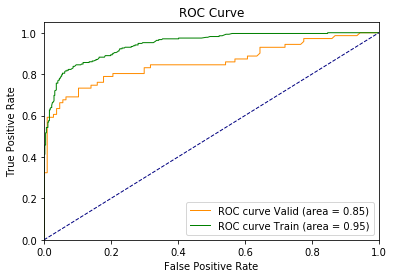

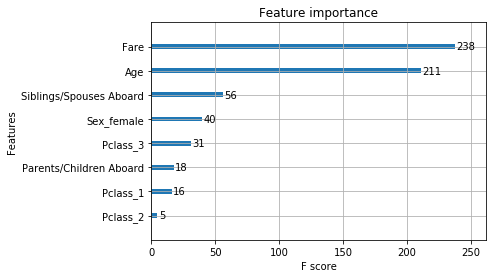

In [15]:
#plot ROC

from sklearn.metrics import roc_auc_score, roc_curve, auc

probs_train = xgb_model.predict_proba(x_train)
probs_valid = xgb_model.predict_proba(x_valid)

probs_train = probs_train[:,1]
probs_valid = probs_valid[:,1]

auc_valid=roc_auc_score(y_valid, probs_valid)
auc_train=roc_auc_score(y_train, probs_train)

fpr1, tpr1, thresholds1 = roc_curve(y_valid, probs_valid)
fpr2, tpr2, thresholds2 = roc_curve(y_train, probs_train)

plt.figure()
lw=1
plt.plot(fpr1, tpr1, color='darkorange',
         lw=lw, label='ROC curve Valid (area = %0.2f)' % auc_valid)
plt.plot(fpr2, tpr2, color='green',
         lw=lw, label='ROC curve Train (area = %0.2f)' % auc_train)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

#plot feature importance

plot_importance(xgb_model)

In [19]:
#Create the grid for grid search

learn_rate = [0.1, 0.09]
n_estimators = [100, 200, 300]
max_depth = [3, 6, 9]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, learn_rate=learn_rate)

#search the grid
grid = GridSearchCV(estimator=xgb.XGBClassifier(), 
                    param_grid=param_grid,
                    cv=3,
                    scoring = 'roc_auc',
                    verbose=2,
                    n_jobs=-1)

grid_result = grid.fit(x_train, y_train.values.ravel())

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    5.7s finished


In [20]:
# summarize results of grid search

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

#print full results
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.871253 using {'learn_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
0.868785 (0.010344) with: {'learn_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.871253 (0.005081) with: {'learn_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
0.867476 (0.002671) with: {'learn_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
0.857302 (0.008723) with: {'learn_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
0.854302 (0.005872) with: {'learn_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
0.850265 (0.009957) with: {'learn_rate': 0.1, 'max_depth': 6, 'n_estimators': 300}
0.852607 (0.004545) with: {'learn_rate': 0.1, 'max_depth': 9, 'n_estimators': 100}
0.849671 (0.012957) with: {'learn_rate': 0.1, 'max_depth': 9, 'n_estimators': 200}
0.845511 (0.016115) with: {'learn_rate': 0.1, 'max_depth': 9, 'n_estimators': 300}
0.868785 (0.010344) with: {'learn_rate': 0.09, 'max_depth': 3, 'n_estimators': 100}
0.871253 (0.005081) with: {'learn_rate': 0.09, 'max_depth': 3, 'n_estimators': 200}
0.86747

In [35]:
#score dataset with optimal parameters

final_xgb = xgb.XGBClassifier(learn_rate= 0.1, max_depth= 3, n_estimators= 200,
                               objective= 'binary:logistic', scoring = 'roc_auc')

final_xgb.fit(x_train, y_train.values.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learn_rate=0.1, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=200, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, scoring='roc_auc', seed=None,
       silent=True, subsample=1)

AUC_Train: 0.964
AUC_Valid: 0.840


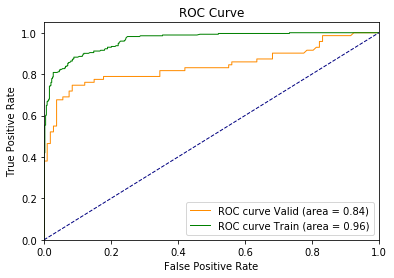

In [39]:
#print ROC

from sklearn.metrics import roc_auc_score, roc_curve, auc

probs_train = final_xgb.predict_proba(x_train)
probs_valid = final_xgb.predict_proba(x_valid)

probs_train = probs_train[:,1]
probs_valid = probs_valid[:,1]

auc_valid=roc_auc_score(y_valid, probs_valid)
auc_train=roc_auc_score(y_train, probs_train)
print('AUC_Train: %.3f' % auc_train)
print('AUC_Valid: %.3f' % auc_valid)


fpr1, tpr1, thresholds1 = roc_curve(y_valid, probs_valid)
fpr2, tpr2, thresholds2 = roc_curve(y_train, probs_train)

plt.figure()
lw=1
plt.plot(fpr1, tpr1, color='darkorange',
         lw=lw, label='ROC curve Valid (area = %0.2f)' % auc_valid)
plt.plot(fpr2, tpr2, color='green',
         lw=lw, label='ROC curve Train (area = %0.2f)' % auc_train)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

Age = 0.041924905
Siblings/Spouses Aboard = 0.058279075
Parents/Children Aboard = 0.016885752
Fare = 0.034302723
Pclass_1 = 0.11018739
Pclass_2 = 0.018258601
Pclass_3 = 0.21464097
Sex_female = 0.5055205
Sex_male = 0.0


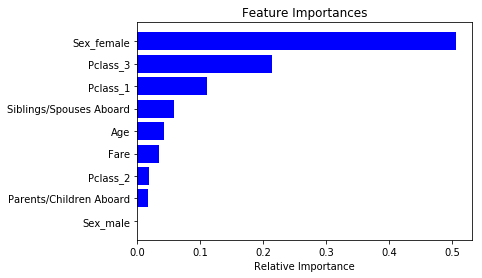

In [40]:
#print Variable importance

for name, importance in zip(x_train.columns, final_xgb.feature_importances_):
        print(name, '=', importance)
        
features = x_train.columns
importances = final_xgb.feature_importances_
indices=np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()